In [17]:
import os
import json
import operator
from typing import TypedDict, Annotated, Optional

from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
from langgraph.types import Command, interrupt
from pymongo import MongoClient
from langgraph.checkpoint.mongodb import MongoDBSaver
from langgraph.store.mongodb.base import MongoDBStore


import os
from pymongo import MongoClient
import traceback

import asyncio
import time
import functools
import logging

from dotenv import load_dotenv


from pydantic import BaseModel, Field
from typing import List, Optional
from langmem import (
    create_memory_store_manager,
    create_prompt_optimizer,
    create_manage_memory_tool,
    create_search_memory_tool
)

load_dotenv()  # <-- MUST be at the very top before any os.getenv

APIFY_TOKEN = os.getenv("APIFY_API_KEY")  #

# Set up basic logging
logging.basicConfig(level=logging.INFO)

# Circuit breaker state
circuit_open = False
failure_count = 0
failure_threshold = 3  # Open circuit after 3 consecutive failures
circuit_reset_time = 30  # seconds
last_failure_time = 0


# --- Define the Pydantic Schema right after your AgentState class ---
class CareerMemory(BaseModel):
    """A structured memory for storing insights about a user's career planning session."""
    career_goal: str = Field(description="The user's specific career objective or transition goal")
    timeline: Optional[str] = Field(description="Timeframe mentioned for achieving the goal")
    current_role: Optional[str] = Field(description="User's current position/role")
    target_role: Optional[str] = Field(description="Desired position/role")
    key_skills_needed: Optional[List[str]] = Field(description="Important skills mentioned or needed")
    learning_preferences: Optional[str] = Field(description="Preferred learning methods or platforms")
    industry_focus: Optional[str] = Field(description="Target industry or domain of interest")
    success_strategies: Optional[str] = Field(description="Approaches that have worked well for similar goals")
    common_obstacles: Optional[str] = Field(description="Challenges typically faced in this type of transition")
    resource_recommendations: Optional[str] = Field(description="Specific courses, tools, or resources that proved effective")
    
    




def llm_call_with_retry_circuit(prompt: str, max_retries=3, retry_delay=2):
    """
    Wrapper for model.generate_content with:
    - Retry on transient errors
    - Circuit breaker to stop repeated failures
    - Token/cost logging
    """
    global circuit_open, failure_count, last_failure_time

    # Circuit breaker check
    if circuit_open:
        if time.time() - last_failure_time < circuit_reset_time:
            logging.warning("Circuit open. Skipping LLM call.")
            raise RuntimeError("Circuit open due to repeated failures")
        else:
            logging.info("Resetting circuit breaker.")
            circuit_open = False
            failure_count = 0

    for attempt in range(1, max_retries + 1):
        try:
            res = model.generate_content(prompt)

            # Logging token/cost info if available
            if hasattr(res, "usage"):
                tokens = res.usage.get("total_tokens", "N/A")
                cost = tokens * 0.00001  # Example: adjust based on model pricing
                logging.info(
                    f"LLM call successful | Tokens used: {tokens} | Est. cost: ${cost:.6f}"
                )

            # Reset failure count on success
            failure_count = 0
            return res

        except Exception as e:
            logging.warning(f"LLM call failed on attempt {attempt}: {e}")
            failure_count += 1
            last_failure_time = time.time()
            if failure_count >= failure_threshold:
                circuit_open = True
                logging.error(
                    f"Circuit opened after {failure_count} consecutive failures."
                )
            if attempt < max_retries:
                time.sleep(retry_delay)
            else:
                raise RuntimeError(f"LLM call failed after {max_retries} attempts: {e}")


# Try to use MongoDB persistence, fallback to memory if not available
try:
    mongo_uri = os.getenv("MONGODB_URI", "mongodb://localhost:27017")
    mongo_client = MongoClient(mongo_uri)
    mongo_client.admin.command("ping")

    # Define the LLM instance once
    llm = ChatGoogleGenerativeAI(
        model="gemini-1.5-flash",
        google_api_key=os.getenv("GOOGLE_API_KEY"),
        temperature=0.7
    )

    # 1. Graph Checkpointer (CORRECTED INSTANTIATION)
    # We instantiate MongoDBSaver directly instead of using the context manager.
    checkpoint_db = mongo_client["career_bot_checkpoints"]
    checkpointer = MongoDBSaver(
    client=mongo_client,  # <-- THIS IS THE MISSING ARGUMENT
    collection=checkpoint_db["checkpoints"]
)

    # 2. LangMem Memory Store
    db = mongo_client["career_bot_memories"]
    memory_store = MongoDBStore(collection=db["procedural_memories"])

    # 3. Create the Memory Store Manager - The Core Component
    # This single manager handles persistence, extraction, and updates.
    memory_store_manager = create_memory_store_manager(
        llm,                      # The LLM is the required positional-only first argument
        schemas=[CareerMemory],   # The Pydantic class defines the shape of our memories
        store=memory_store
    )

    # 4. Create the other tools as requested
    prompt_optimizer = create_prompt_optimizer(llm)
    manage_memory_tool = create_manage_memory_tool(memory_store_manager)
    search_memory_tool = create_search_memory_tool(memory_store_manager)

    print("✅ LangMem procedural learning system initialized successfully.")
    LANGMEM_AVAILABLE = True

except Exception as e:
    print(f"❌ LangMem initialization failed: {e}\n{traceback.format_exc()}")
    # Your original fallback logic...
    from langgraph.checkpoint.memory import MemorySaver
    checkpointer = MemorySaver()
    memory_store_manager = None
    prompt_optimizer = None
    manage_memory_tool = None
    search_memory_tool = None
    LANGMEM_AVAILABLE = False


import google.generativeai as genai
from scraper_utils import scrape_and_clean_profile

genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))
model = genai.GenerativeModel("models/gemini-1.5-flash")


class AgentState(TypedDict, total=False):
    messages: Annotated[list[BaseMessage], operator.add]
    profile_data: Annotated[dict, lambda _, x: x]
    current_job_description: Annotated[Optional[str], lambda _, x: x]
    linkedin_url: Annotated[Optional[str], lambda _, x: x]
    thread_id: Annotated[Optional[str], lambda _, x: x]  
    websearch_results: Annotated[list, lambda _, x: x]
    websearch_summary: Annotated[list, lambda _, x: x]
    # FIX 1: Add flag to track if profile was already scraped
    profile_scraped: Annotated[bool, lambda _, x: x]


from apify_client import ApifyClient
import time

# FIX 3: Improved websearch with better error handling and link extraction
def websearch_mcp_node(state: AgentState) -> dict:
    messages = state.get("messages", [])
    messages.append(AIMessage("🔍 Fetching web data..."))

    query = ""
    for msg in reversed(messages):
        if isinstance(msg, HumanMessage):
            query = msg.content.strip()
            break

    if not query:
        messages.append(AIMessage("⚠ No query provided for web search."))
        state["messages"] = messages
        return state

    api_token = os.getenv("APIFY_API_KEY")
    if not api_token:
        messages.append(AIMessage("❌ Apify API token not configured."))
        state["messages"] = messages
        return state

    client = ApifyClient(api_token)
    actor_id = "apify/google-search-scraper"
    input_data = {"queries": [query], "maxPagesPerQuery": 1, "resultsPerPage": 5, "countryCode": "US", "languageCode": "en"}
    max_retries = 3
    retry_delay = 2
    results = []

    for attempt in range(1, max_retries + 1):
        try:
            logging.info(f"Starting Apify web search for: {query}")
            run = client.actor(actor_id).call(run_input=input_data)
            dataset_items = client.dataset(run["defaultDatasetId"]).list_items().items
            logging.info(f"Retrieved {len(dataset_items)} items from Apify")
            
            for item in dataset_items:
                search_results = item.get("searchResults", [])
                for result in search_results:
                    results.append({"title": result.get("title", ""), "link": result.get("url", ""), "snippet": result.get("description", "")})

            if results:
                messages.append(AIMessage(f"🔍 WebSearch results fetched via Apify ({len(results)} results):\n" + "\n".join([f"- {r['title']}: {r['link']}" for r in results[:3]])))
                logging.info(f"Successfully found {len(results)} web search results")
            else:
                messages.append(AIMessage("⚠ No search results found."))
            break
        except Exception as e:
            logging.error(f"Apify search attempt {attempt} failed: {e}")
            if attempt < max_retries:
                messages.append(AIMessage(f"⚠ Apify attempt {attempt} failed. Retrying..."))
                time.sleep(retry_delay)
            else:
                messages.append(AIMessage(f"❌ Apify WebSearch failed after {max_retries} attempts: {e}"))

    state["messages"] = messages
    state["websearch_results"] = results
    return state

def enrich_websearch_node(state):
    messages = state.get("messages", [])
    results = state.get("websearch_results", [])
    if not results:
        messages.append(AIMessage("⚠ No search results to enrich."))
        state["messages"] = messages
        return state

    summary = []
    for r in results:
        content = r.get("snippet") or r.get("content") or r.get("description", "")
        if not content and r.get("link"):
            try:
                import requests
                response = requests.get(r["link"], timeout=10, headers={'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'})
                content = response.text[:2000]
            except Exception as e:
                content = f"Could not fetch content: {e}"
        try:
            if content and len(content) > 50:
                summary_prompt = f"Summarize the key points for career planning from this content:\n\n{content[:1500]}"
                # - MODIFICATION: Using the synchronous LLM call
                res = llm_call_with_retry_circuit(summary_prompt)
                summary_text = res.text
            else:
                summary_text = content or "No content available"
            summary.append({"title": r["title"], "link": r["link"], "summary": summary_text[:500]})
        except Exception as e:
            logging.error(f"Error enriching search result: {e}")
            summary.append({"title": r["title"], "link": r["link"], "summary": f"❌ Could not summarize: {e}"})

    messages.append(AIMessage(f"✅ Search results enriched with AI summaries ({len(summary)} results)."))
    state["messages"] = messages
    state["websearch_summary"] = summary
    return state


def store_websearch_node(state: AgentState) -> dict:
    try:
        client = MongoClient(os.getenv("MONGODB_URI", "mongodb://localhost:27017"))
        db = client["career_bot"]
        collection = db["websearch"]
        results = state.get("websearch_summary", [])
        if results:
            import datetime
            for result in results:
                result["timestamp"] = datetime.datetime.utcnow().isoformat()
                result["thread_id"] = state.get("thread_id", "unknown")
            collection.insert_many(results)
            state["messages"].append(AIMessage(f"💾 Stored {len(results)} search results in DB."))
        else:
            state["messages"].append(AIMessage("⚠ Nothing to store."))
    except Exception as e:
        logging.error(f"Error storing websearch results: {e}")
        state["messages"].append(AIMessage("⚠ Failed to store search results."))
    return state

# FIX 1: Improved LinkedIn scraper that only runs when needed
def linkedin_scraper_node(state: dict) -> dict:
    """
    Scrapes LinkedIn profile URL only if not already scraped in this session.
    """
    messages = state.get("messages", [])
    thread_id = state.get("thread_id", "default_thread")
    profile_scraped = state.get("profile_scraped", False)
    existing_profile = state.get("profile_data")

    # FIX 1: Skip scraping if profile already exists and was scraped
    if profile_scraped and existing_profile:
        logging.info("Profile already scraped in this session, skipping scraper")
        return Command(goto=["career_qa_router"], update=state)

    linkedin_url = state.get("linkedin_url", "").strip()

    if not linkedin_url:
        messages.append(AIMessage("Please provide a LinkedIn profile URL to begin."))
        state["messages"] = messages
        return interrupt("continue_chat")

    messages.append(AIMessage("Scraping your LinkedIn profile..."))

    try:
        scraped_profile = scrape_and_clean_profile(
            linkedin_url=linkedin_url, api_token=os.getenv("APIFY_API_KEY")
        )

        if not scraped_profile:
            messages.append(AIMessage("Failed to extract profile. Try again."))
            state["messages"] = messages
            return interrupt("continue_chat")

        messages.append(AIMessage("Profile successfully scraped!"))
        state["profile_data"] = scraped_profile
        state["profile_scraped"] = True  # FIX 1: Mark as scraped
        state["messages"] = messages
        state["thread_id"] = thread_id

    except Exception as e:
        messages.append(AIMessage(f"Error scraping LinkedIn profile: {e}"))
        state["messages"] = messages
        return interrupt("continue_chat")

    return Command(goto=["career_qa_router"], update=state)


def career_qa_router(state: AgentState) -> Command:
    profile = state.get("profile_data", {})
    jd = state.get("current_job_description", "")
    messages = state.get("messages", [])
    question = ""

    for msg in reversed(messages):
        if isinstance(msg, HumanMessage):
            question = msg.content.strip()
            break

    if question.lower() in {"quit", "exit", "stop"}:
        messages.append(AIMessage("Okay, ending the conversation."))
        return Command(goto=END, update={"messages": messages})

    if "job description:" in question.lower():
        messages.append(AIMessage("Got your new job description."))
        state["messages"] = messages
        state["current_job_description"] = question
        return interrupt("continue_chat")

    # FIX 3: Check if web search is needed for this query
    if any(keyword in question.lower() for keyword in [
        "course", "learn", "certification", "training", "resource", 
        "website", "online", "platform", "bootcamp", "tutorial"
    ]):
        logging.info("Query requires web search, routing to websearch first")
        return Command(goto="websearch_mcp", update=state)

    history = "\n".join(
        f"Human: {m.content}" if isinstance(m, HumanMessage) else f"AI: {m.content}"
        for m in messages[-5:]
    )
    prompt = f"""
    {history}
You are a routing agent. Decide which module should handle the user's latest question.

Return one of:
- analyze_profile
- job_fit_agent
- enhance_profile
- career_plan
- general_qa

DO NOT GUESS. Use the following rules:

---

ROUTE TO: analyze_profile
→ If the user wants a LinkedIn/resume/profile review, feedback, strengths, weaknesses, or audit.

Examples:
- "Can you review my LinkedIn?"
- "What are my strengths and weaknesses?"
- "Audit my profile"
- Or any other question that implies analyzing the profile.
---

ROUTE TO: job_fit_agent
→ If the user says anything like:
- "Does my profile match this JD?"
- "Am I eligible for this job?"
- "Score me against this role"
- Or any other question that implies matching the profile to a job description.

Only route here if a job description was recently provided.

---

ROUTE TO: enhance_profile
→ If the user asks for:
- Rewriting/resume improvement
- Profile optimization
- "Improve my About section"
- "Rewrite my Experience bullets"
- Or any other question that implies enhancing the profile.

---

ROUTE TO: career_plan
→ If the user wants a career plan, roadmap, or action plan.

Examples:
- "Create a career plan for me"
- "Give me a roadmap to become a data scientist"
- "I want a 30-60-90 day plan"
- "Help me plan my career transition"
- Or any other question that implies creating a structured career plan.

---

ROUTE TO: general_qa
→ All other general career questions.

Examples:
- "What kind of roles should I target?"
- "How do I switch fields?"
- "What are good certifications for data science?"
- "How do I get into startups?"
- Or any other question that doesn't fit the above categories.

---

USER QUESTION:
{question}

Just respond with ONE of:
analyze_profile, job_fit_agent, enhance_profile, career_plan, general_qa
"""

    try:
        result = llm_call_with_retry_circuit(prompt)
        decision = result.text.strip().lower()

        if decision in {
            "analyze_profile",
            "job_fit_agent",
            "enhance_profile",
            "career_plan",
            "general_qa",
        }:
            state["messages"] = messages

            return Command(
                goto=decision if decision != "general_qa" else "general_qa_node",
                update=state
            )

        else:
            messages.append(AIMessage("⚠ I didn't understand. Try rephrasing."))
            state["messages"] = messages
            return interrupt("continue_chat")
    except Exception as e:
        messages.append(AIMessage(f"⚠ Routing error: {e}"))
        state["messages"] = messages
        return interrupt("continue_chat")


def analyze_profile_node(state: AgentState) -> dict:
    profile = state.get("profile_data")
    messages = state["messages"]
    if not profile:
        messages.append(AIMessage("⚠ No profile data found to analyze."))
        state["messages"] = messages
        return interrupt("continue_chat")

    profile_text = "\n".join(f"{k}: {v}" for k, v in profile.items())
    history = "\n".join(
        f"Human: {m.content}" if isinstance(m, HumanMessage) else f"AI: {m.content}"
        for m in messages[-5:]
    )

    prompt = f"""
{history}
        You are a highly experienced career coach and tech recruiter who has reviewed over 10,000 LinkedIn profiles.

        Your job is to critically evaluate the following LinkedIn profile and return a brutally honest, section-wise analysis.

        Use the following criteria for evaluation:
        1. Clarity and professionalism of writing
        2. Technical and strategic relevance of content
        3. Recruiter impression: Would you shortlist this profile?

        ---

        {profile_text}

        ---

        ### Return output in the following structure:

        # LinkedIn Profile Audit

        ## Strengths  
        List 3–5 strengths that stand out across the profile.

        ## Weaknesses  
        List 3–5 major weaknesses holding the profile back.
 ## Section-by-Section Evaluation  
        For each section (About, Experience, Projects, Education, Skills, etc.), write:

        - Give a quality score: ✅ Strong / ⚠ Needs improvement / ❌ Missing  
        - Provide 2–3 suggestions to improve the section (content, phrasing, structure)  
        - Use clean formatting: bold headings, bullet points, and avoid unnecessary repetition.

        Constraints:
        - Max 4 bullet points per section  
        - Each bullet: <30 words  
        - Total section feedback: <100 words

        ## Top 3 Improvements You Must Make Now  
        Each point must be:
        - Brutally specific  
        - Directly actionable  
        - One line only
        
        Precautions:
        - Do not hallucinate and stay within context.
        - If the user asks for/about a specific section (e.g., "improve my projects"), focus only on that section.
        
        Begin now.
        """.strip()

    try:
        res = llm_call_with_retry_circuit(prompt)
        messages.append(AIMessage(res.text))
        state["messages"] = messages
    except Exception as e:
        messages.append(AIMessage(f"❌ Error: {e}"))
        state["messages"] = messages

    return interrupt("continue_chat")


def job_fit_agent_node(state: AgentState) -> dict:
    profile = state.get("profile_data")
    jd = state.get("current_job_description", "")
    messages = state["messages"]
    if not profile or not jd:
        messages.append(AIMessage("⚠ Missing profile or job description."))
        state["messages"] = messages
        return interrupt("continue_chat")

    profile_text = "\n".join(f"{k}: {v}" for k, v in profile.items())
    history = "\n".join(
        f"Human: {m.content}" if isinstance(m, HumanMessage) else f"AI: {m.content}"
        for m in messages[-5:]
    )

    prompt = f"""
{history}
        You are a highly experienced AI Job Fit Evaluator trained on thousands of hiring decisions across several job roles.
        Your job is to evaluate how well the candidate's profile matches the given job description.       
        ---

        JOB DESCRIPTION:
        {jd}

        CANDIDATE PROFILE:
        {profile_text}

        ---

        TASKS:
        1. Evaluate the fitness of the candidate for this job role using industry-standard evaluation practices (skills, experience, keywords, impact, achievements, and alignment).
        2. Return a Job Match Score out of 100, and explain how you arrived at it with specific reasoning.
        3. List 3–5 strengths from the candidate's profile that match the job expectations.
        4. Suggest 3–5 concrete improvements – these could include skill gaps, experience tweaks, weak areas in phrasing, or missing proof of impact.
  5. Only evaluate against the given job role. Do not assume adjacent job titles are valid matches.
        6. If the candidate seems overqualified or underqualified, clearly state it and explain how that affects the match.

        ---

        OUTPUT FORMAT:
        # 🎯 Job Fit Evaluation

        ## ✅ Job Match Score: XX/100
        - One-line explanation of the score.
        - 2–3 bullets with specific justification.

        ## 🟩 Strengths
        - Point 1 (aligned with JD)
        - Point 2
        - Point 3  
        (Each point ≤ 40 words)

 ## 🟥 Weaknesses
        - specify the top 3-4 points as to why this profile doesn't match the job or will get rejected even if applied and this analysis must be honest and brutal
        (Each point ≤ 40 words)

        ## 🛠 Improvements to Increase Match Score
        - Point 1 (what to improve and how)
        - Point 2
        - Point 3  
        (Each point ≤ 25 words)

        ## 📌 Verdict
        Clearly say if the candidate is a strong match, weak match, or needs improvement to apply. Give a one-liner summary.
        
        Precautions:
        - Do not hallucinate and stay within context.
        - If the user asks for/about a specific section (e.g., "improve my projects"), focus only on that section.
        
        Begin now.
""".strip()

    try:
        res = llm_call_with_retry_circuit(prompt)

        messages.append(AIMessage(res.text))
        state["messages"] = messages
    except Exception as e:
        messages.append(AIMessage(f"❌ Error: {e}"))
        state["messages"] = messages

    return interrupt("continue_chat")


def enhance_profile_node(state: AgentState) -> dict:
    profile = state.get("profile_data")
    jd = state.get("current_job_description", "")
    messages = state["messages"]
    if not profile:
        messages.append(AIMessage("⚠ No profile found to enhance."))
        state["messages"] = messages
        return interrupt("continue_chat")

    profile_text = "\n".join(f"{k}: {v}" for k, v in profile.items())
    history = "\n".join(
        f"Human: {m.content}" if isinstance(m, HumanMessage) else f"AI: {m.content}"
        for m in messages[-5:]
    )

    prompt = f"""
{history}
        You are a highly experienced LinkedIn Profile Optimization AI, trained on millions of real-world hiring patterns across top companies like Google, Amazon, Meta, and startups. Your task is to analyze and rewrite the user's LinkedIn profile to improve clarity, strength, and impact.

        CONTEXT:
        - The user may or may not have shared a job description.
        - They might be asking to improve a specific section only (e.g., "improve my projects to match this JD").
        - You should infer goals from the user's question and adjust accordingly.
        - If any question is related to the job description/JD then consider that and then provide an output

        CURRENT PROFILE:
        {profile_text}  

        JOB DESCRIPTION/JD:
        {jd}
  TASKS:
        1. Identify weak sections and rewrite them to be stronger, more professional, and better aligned with either:
            - the job description (if provided), or
            - general hiring best practices (if no JD is given).
        2. Preserve all factual details. Do NOT add imaginary experiences.
        3. Use bullet points only where appropriate (e.g., Experience, Projects).
        4. Each bullet must be ≤ 25 words, and **max 4 bullets per section.
        5. For the "About" section, limit to 2–3 tight paragraphs, total **≤ 250 words.
        6. Add impactful verbs, metrics, and proof of value wherever possible.
        7. If the user requested only a section enhancement (e.g., just projects), modify only that section.
        8. If the user asks for a specific section (e.g., "improve my projects"), focus only on that section, DO NOT TALK ABOUT OTHER SECTIONS.

        FORMAT:
        Return the improved sections in clean Markdown format.
        - Use bold section titles.
        - Show only modified sections – skip untouched ones to save tokens.
        - Make sure the rewritten content feels real, focused, and hiring-ready.

Precautions:
        - Do not hallucinate and stay within context.
        - If the user asks for/about a specific section (e.g., "improve my projects"), focus only on that section.

        Begin now.
""".strip()

    try:
        res = llm_call_with_retry_circuit(prompt)

        messages.append(AIMessage(res.text))
        state["messages"] = messages
    except Exception as e:
        messages.append(AIMessage(f"❌ Error: {e}"))
        state["messages"] = messages

    return interrupt("continue_chat")


def general_qa_node(state: AgentState) -> dict:
    messages = state["messages"]
    question = ""
    for msg in reversed(messages):
        if isinstance(msg, HumanMessage):
            question = msg.content.strip()
            break

    history = "\n".join(
        f"Human: {m.content}" if isinstance(m, HumanMessage) else f"AI: {m.content}"
        for m in messages[-5:]
    )

    prompt = f"""
You are a helpful, concise, and highly experienced career guidance assistant.

Your task is to answer general career-related questions from users

The user may ask about:
- Career advice
- Interview preparation
- Certifications
- Job search strategy
- Skill-building
- Remote work
- Career switches
- Industry trends
- Anything else loosely related to career growth

---

USER CONTEXT (optional):
{history}

PROFILE DATA:
{state.get("profile_data", "N/A")}

JOB DESCRIPTION (if any):
{state.get("current_job_description", "N/A")}

QUESTION:
{question}

---

### Answer Guidelines:

- Answer clearly and concisely.
- Prioritize useful, actionable advice.
- If the question is vague or broad, ask a clarifying follow-up.
- Keep the tone supportive but professional.
- Do not suggest uploading a resume or LinkedIn again.
- If you detect the user is stressed, confused, or unsure, acknowledge that supportively.

---

### Output Format:

Respond in clean text. Use bullet points or short paragraphs where needed.

Start now.
""".strip()

    try:
        res = llm_call_with_retry_circuit(prompt)

        messages.append(AIMessage(res.text))
        state["messages"] = messages
    except Exception as e:
        messages.append(AIMessage(f"❌ Error: {e}"))
        state["messages"] = messages

    return interrupt("continue_chat")





# MCP client setup (keep same as original)
from mcp import ClientSession, StdioServerParameters
from mcp.client.stdio import stdio_client
import sys

CAREER_PLAN_SERVER = os.path.abspath(
    "E:\\LinkedIn_AI_Career_Bot - Copy\\linkedin\\career_plan_mcp.py"
)

def call_career_plan_mcp(profile_data, messages, system_prompt):
    """Async call to the career-plan MCP tool."""
    server_params = StdioServerParameters(
        command=sys.executable,
        args=[CAREER_PLAN_SERVER],
    )

    with stdio_client(server_params) as (read, write):
        with ClientSession(read, write) as session:
            session.initialize()
            result = session.call_tool(
                "generate_career_plan",
                arguments={
                    "profile_data": profile_data,
                    "messages": [
                        {
                            "role": "system",
                            "content": system_prompt,
                        }
                    ] + [
                        {
                            "role": (
                                "user" if isinstance(m, HumanMessage) else "assistant"
                            ),
                            "content": m.content,
                        }
                        for m in messages
                    ],
                },
            )
            return result.content[0].text


def get_user_id_from_profile(profile: dict) -> str:
    """Extract user ID from profile"""
    return profile.get("user_id", 
           profile.get("email", 
           profile.get("linkedin_url", 
           f"user_{hash(str(profile))}")))


def extract_latest_user_query(messages: list[BaseMessage]) -> str:
    """Extract the latest user query from messages"""
    for msg in reversed(messages):
        if isinstance(msg, HumanMessage):
            return msg.content.strip()
    return ""


# FIX 2: Enhanced career plan node with proper context preservation
# agents.py - The New Procedural Career Plan Node

def procedural_career_plan_node(state: AgentState) -> dict:
    """
    Career planning node with full, optimized LangMem procedural learning.
    """
    if not LANGMEM_AVAILABLE:
        return interrupt({"messages": [AIMessage("Memory system is unavailable. Cannot create a procedural plan.")]})

    messages = state["messages"]
    profile_data = state.get("profile_data", {})
    user_query = extract_latest_user_query(messages)

    if not user_query:
        return interrupt({"messages": [AIMessage("Please provide your career goal to generate a plan.")]})

    user_namespace = f"user_{hash(str(profile_data))}" if profile_data else "anonymous"
    memory_context = ""

    # Step 1: SEARCH for relevant structured memories using the langmem tool
    try:
        search_results = search_memory_tool.invoke({
            "query": user_query, "namespace": user_namespace, "top_k": 3
        })
        if search_results:
            logging.info(f"Found {len(search_results)} relevant memories.")
            memory_context = "\n\nLEARNINGS FROM PAST SESSIONS:\n"
            for mem in search_results:
                content = mem.get('value', {}).get('content', {})
                memory_context += f"- For a goal like '{content.get('career_goal', 'N/A')}', a successful strategy was: '{content.get('success_strategies', 'N/A')}'.\n"
                memory_context += f"  - A common obstacle to watch for is: '{content.get('common_obstacles', 'N/A')}'.\n"
    except Exception as e:
        logging.error(f"Memory search failed: {e}")

    # Step 2: BUILD the base prompt with augmented memory context
    base_prompt = f"""
You are an expert AI career coach. Create a personalized and actionable career plan.

USER PROFILE: {json.dumps(profile_data, indent=2)}
LATEST REQUEST: {user_query}
{memory_context}

INSTRUCTIONS:
- Create a comprehensive career plan based on the user's profile and request.
- If learnings from past sessions are available, incorporate those successful strategies.
- Provide concrete steps, realistic timelines, and suggest key resources.
"""

    # Step 3: OPTIMIZE the prompt using the langmem tool
    final_prompt = base_prompt
    try:
        examples = [{"input": messages[i].content, "output": messages[i+1].content} for i in range(0, len(messages)-1, 2)]
        if examples:
            opt_result = prompt_optimizer.invoke({
                "prompt": base_prompt, "examples": examples[-2:],
                "feedback": "Make the career plan more actionable and personalized."
            })
            final_prompt = opt_result.get("optimized_prompt", base_prompt)
            logging.info("Prompt optimized for clarity and actionability.")
    except Exception as e:
        logging.error(f"Prompt optimization failed: {e}")

    # Step 4: GENERATE the career plan using your MCP
    try:
        plan_output = call_career_plan_mcp(profile_data, messages, final_prompt)
    except Exception as e:
        plan_output = f"Error generating career plan: {e}"
        logging.error(f"Career plan generation failed: {e}")

    # Step 5: STORE the interaction. The memory manager will automatically extract and save structured insights.
    if "Error" not in plan_output:
        try:
            conversation_to_learn_from = [HumanMessage(content=user_query), AIMessage(content=plan_output)]
            memory_store_manager.invoke(
                {"messages": conversation_to_learn_from, "namespace": user_namespace}
            )
            logging.info("Interaction stored and processed by the memory manager.")
            plan_output += "\n\n*💾 Insights from this session have been saved to improve future advice.*"
        except Exception as e:
            logging.error(f"Failed to store procedural memories: {e}")

    return interrupt({"messages": [AIMessage(content=plan_output)]})


# agents.py - Utility function using the manage_memory_tool

async def clear_user_memories(profile_data: dict) -> dict:
    """
    Clears all procedural memories for a given user profile using the manage_memory_tool.
    """
    if not LANGMEM_AVAILABLE or not profile_data:
        return {"error": "Memory management not available or profile not loaded."}
    
    try:
        user_namespace = f"user_{hash(str(profile_data))}"
        result = await manage_memory_tool.ainvoke({
            "action": "clear",
            "namespace": user_namespace
        })
        logging.info(f"Cleared all memories for namespace: {user_namespace}")
        return {"success": True, "message": f"All memories for the current profile have been cleared."}
    except Exception as e:
        logging.error(f"Failed to clear memories: {e}")
        return {"error": str(e)}

# Don't forget to update your __all__ export list at the bottom of the file
# to include this new function if you want to import it elsewhere.
# __all__ = [..., "clear_user_memories"]


def build_graph():
    """Build the graph with all fixes applied"""
    builder = StateGraph(AgentState)
    
    # Add all nodes
    builder.add_node("linkedin_scraper", linkedin_scraper_node)
    builder.add_node("career_qa_router", career_qa_router)
    builder.add_node("analyze_profile", analyze_profile_node)
    builder.add_node("job_fit_agent", job_fit_agent_node)
    builder.add_node("enhance_profile", enhance_profile_node)
    builder.add_node("general_qa_node", general_qa_node)
    builder.add_node("career_plan", procedural_career_plan_node)
    
    # FIX 3: Web search nodes
    builder.add_node("websearch_mcp", websearch_mcp_node)
    builder.add_node("enrich_websearch", enrich_websearch_node)
    builder.add_node("store_websearch", store_websearch_node)
    
    # Define entry point
    builder.set_entry_point("linkedin_scraper")
    
    # FIX 1: LinkedIn scraper goes to router (not both router and career_plan)
    builder.add_edge("linkedin_scraper", "career_qa_router")
    
    # Router connections
    builder.add_edge("career_qa_router", "analyze_profile")
    builder.add_edge("career_qa_router", "job_fit_agent")
    builder.add_edge("career_qa_router", "enhance_profile")
    builder.add_edge("career_qa_router", "general_qa_node")
    builder.add_edge("career_qa_router", "career_plan")
    
    
    # FIX 3: Web search flow: search -> enrich -> store -> career_plan
    builder.add_edge("career_plan", "store_websearch")
    builder.add_edge("career_plan", "enrich_websearch")
    builder.add_edge("career_plan", "websearch_mcp")
    builder.add_edge("websearch_mcp", "enrich_websearch")
    builder.add_edge("enrich_websearch", "store_websearch")
    builder.add_edge("store_websearch", "career_plan")
    
    # All task nodes loop back to router for continued conversation
    for task in ["analyze_profile", "job_fit_agent", "enhance_profile", "general_qa_node"]:
        builder.add_edge(task, "career_qa_router")

    return builder.compile(checkpointer=checkpointer)


# Create the enhanced graph
graph = build_graph()


def test_thread_based_learning():
    """Test the thread-based procedural learning system"""
    print("=== TESTING THREAD-BASED PROCEDURAL LEARNING ===")
    
    # Test profile data
    test_profile = {
        "headline": "Software Engineer",
        "skills": ["Python", "React", "AWS"],
        "experience": "3 years",
        "user_id": "test_user_123"
    }
    
    # Test storing thread data
    # success = thread_procedural_memory.store_thread_data(
    #     thread_id="test_thread_1",
    #     profile_data=test_profile,
    #     user_query="I want to transition to data science",
    #     ai_response="Here's a comprehensive data science transition plan: 1. Learn Python for data science...",
    #     user_id="test_user_123"
    # )
    
    # print(f"Store test: {'✅ PASSED' if success else '❌ FAILED'}")
    
    # Test retrieval
    # similar_threads = thread_procedural_memory.get_similar_threads(
    #     query="data science career transition",
    #     user_id="test_user_123"
    # )
    
    # print(f"Retrieval test: {'✅ PASSED' if similar_threads else '❌ FAILED'}")
    
    # Debug the test thread
    # thread_procedural_memory.debug_thread("test_thread_1")
    
    print("=== TEST COMPLETE ===")


_all_ = ["graph", "memory", "thread_procedural_memory", "test_thread_based_learning"]


if __name__ == "__main__":
    print("--- Testing Enhanced Thread-Based Procedural Learning ---")
    test_thread_based_learning()
    
    print("\n--- Testing Graph with All Fixes ---")
    
    # Test the complete workflow
    test_state = {
        "messages": [HumanMessage(content="I want to transition from software engineering to AI/ML")],
        "profile_data": {
            "headline": "Senior Software Engineer", 
            "skills": ["Python", "JavaScript", "React"],
            "experience": "5 years",
            "user_id": "test_user_integration"
        },
        "linkedin_url": "https://linkedin.com/in/testuser",
        "thread_id": "integration_test_thread",
        "profile_scraped": True  # Mark as already scraped
    }
    
    try:
        result = graph.invoke(
            test_state,
            config={"configurable": {"thread_id": "integration_test_thread"}}
        )
        
        print("✅ Graph execution successful")
        print(f"Messages generated: {len(result.get('messages', []))}")
        
    except Exception as e:
        print(f"❌ Graph execution failed: {e}")
        traceback.print_exc()

INFO:root:Profile already scraped in this session, skipping scraper


✅ LangMem procedural learning system initialized successfully.
--- Testing Enhanced Thread-Based Procedural Learning ---
=== TESTING THREAD-BASED PROCEDURAL LEARNING ===
=== TEST COMPLETE ===

--- Testing Graph with All Fixes ---


  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-1.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 50
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 15
}
]
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-1.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 50
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 12
}
]
  quota_metric: "generativelanguage.googleapis.com/generate_content_

✅ Graph execution successful
Messages generated: 2815


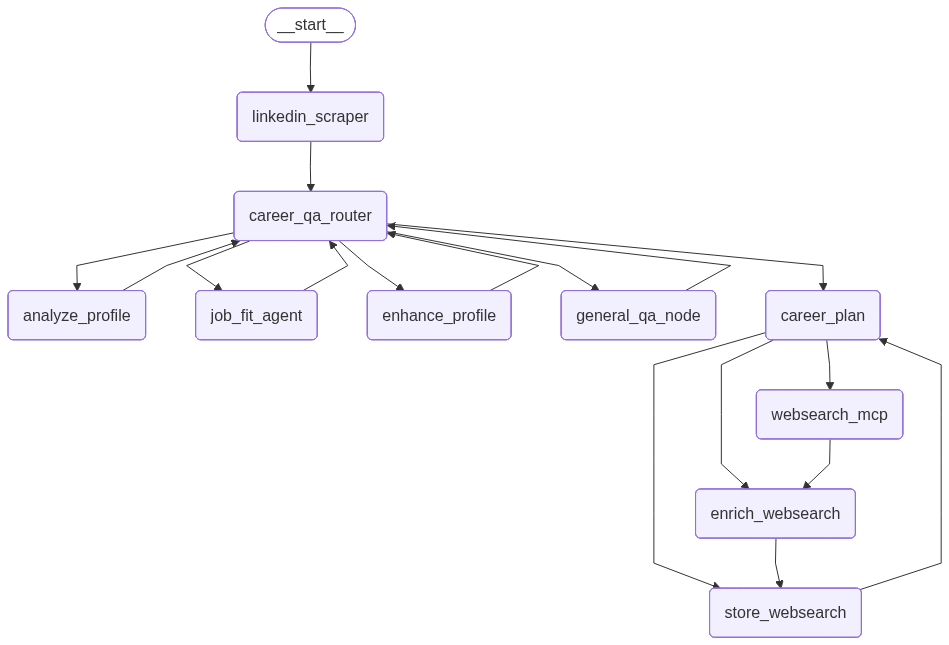

In [18]:
from IPython.display import Image, display
    # Assuming 'graph' is your compiled LangGraph object
display(Image(graph.get_graph().draw_mermaid_png()))

In [1]:
import os
import json
import operator
from typing import TypedDict, Annotated, Optional

from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
from langgraph.types import Command, interrupt

import os
from pymongo import MongoClient
import traceback

import asyncio
import time
import functools
import logging

from dotenv import load_dotenv

load_dotenv()

APIFY_TOKEN = os.getenv("APIFY_API_KEY")

# Set up basic logging
logging.basicConfig(level=logging.INFO)

# Circuit breaker state
circuit_open = False
failure_count = 0
failure_threshold = 3
circuit_reset_time = 30
last_failure_time = 0

def llm_call_with_retry_circuit(prompt: str, max_retries=3, retry_delay=2):
    """Wrapper for model.generate_content with retry and circuit breaker"""
    global circuit_open, failure_count, last_failure_time

    if circuit_open:
        if time.time() - last_failure_time < circuit_reset_time:
            logging.warning("Circuit open. Skipping LLM call.")
            raise RuntimeError("Circuit open due to repeated failures")
        else:
            logging.info("Resetting circuit breaker.")
            circuit_open = False
            failure_count = 0

    for attempt in range(1, max_retries + 1):
        try:
            res = model.generate_content(prompt)
            if hasattr(res, "usage"):
                tokens = res.usage.get("total_tokens", "N/A")
                cost = tokens * 0.00001
                logging.info(f"LLM call successful | Tokens: {tokens} | Cost: ${cost:.6f}")
            failure_count = 0
            return res
        except Exception as e:
            logging.warning(f"LLM call failed on attempt {attempt}: {e}")
            failure_count += 1
            last_failure_time = time.time()
            if failure_count >= failure_threshold:
                circuit_open = True
                logging.error(f"Circuit opened after {failure_count} consecutive failures.")
            if attempt < max_retries:
                time.sleep(retry_delay)
            else:
                raise RuntimeError(f"LLM call failed after {max_retries} attempts: {e}")

# MongoDB setup
try:
    from langgraph.checkpoint.mongodb import MongoDBSaver
    mongo_url = os.getenv("MONGODB_URI", "mongodb://localhost:27017")
    client = MongoClient(mongo_url, serverSelectionTimeoutMS=2000)
    client.admin.command("ping")
    db_name = "career_bot"
    collection_name = "checkpoints"
    db = client["career_bot"]
    collection = db["checkpoints"]
    if collection.count_documents({}) == 0:
        collection.insert_one({"_init": True})
        print(f"Created DB '{db_name}' and collection '{collection_name}'")
    memory = MongoDBSaver(client=client, db_name="career_bot", collection_name="checkpoints")
    print("Using MongoDB persistence")
except Exception as e:
    from langgraph.checkpoint.memory import MemorySaver
    memory = MemorySaver()
    tb = traceback.format_exc()
    print(f"Falling back to in-memory persistence: {e}")

import google.generativeai as genai
from scraper_utils import scrape_and_clean_profile

genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))
model = genai.GenerativeModel("models/gemini-1.5-flash")

# Enhanced State with separate segments
class AgentState(TypedDict, total=False):
    messages: Annotated[list[BaseMessage], operator.add]
    profile_data: Annotated[dict, lambda _, x: x]
    current_job_description: Annotated[Optional[str], lambda _, x: x]
    linkedin_url: Annotated[Optional[str], lambda _, x: x]
    thread_id: Annotated[Optional[str], lambda _, x: x]
    websearch_results: Annotated[list, lambda _, x: x]
    websearch_summary: Annotated[list, lambda _, x: x]
    profile_scraped: Annotated[bool, lambda _, x: x]
    # Segment tracking
    current_segment: Annotated[str, lambda _, x: x]  # 'routing' or 'career_plan'
    # Career plan specific states
    career_plan_draft: Annotated[Optional[str], lambda _, x: x]
    career_plan_review_notes: Annotated[Optional[str], lambda _, x: x]
    career_plan_final: Annotated[Optional[str], lambda _, x: x]
    career_plan_in_review: Annotated[bool, lambda _, x: x]

# Web search functionality
from apify_client import ApifyClient

def websearch_mcp_node(state: AgentState) -> dict:
    messages = state.get("messages", [])
    messages.append(AIMessage("🔍 Fetching web data..."))

    query = ""
    for msg in reversed(messages):
        if isinstance(msg, HumanMessage):
            query = msg.content.strip()
            break

    if not query:
        messages.append(AIMessage("⚠ No query provided for web search."))
        state["messages"] = messages
        return state

    api_token = os.getenv("APIFY_API_KEY")
    if not api_token:
        messages.append(AIMessage("❌ Apify API token not configured."))
        state["messages"] = messages
        return state

    client = ApifyClient(api_token)
    actor_id = "apify/google-search-scraper"
    input_data = {
        "queries": [query], 
        "maxPagesPerQuery": 1,
        "resultsPerPage": 5,
        "countryCode": "US",
        "languageCode": "en"
    }

    max_retries = 3
    retry_delay = 2
    results = []

    for attempt in range(1, max_retries + 1):
        try:
            logging.info(f"Starting Apify web search for: {query}")
            run = client.actor(actor_id).call(run_input=input_data)
            dataset_items = client.dataset(run["defaultDatasetId"]).list_items().items
            logging.info(f"Retrieved {len(dataset_items)} items from Apify")
            
            for item in dataset_items:
                search_results = item.get("searchResults", [])
                for result in search_results:
                    results.append({
                        "title": result.get("title", ""),
                        "link": result.get("url", ""),
                        "snippet": result.get("description", "")
                    })

            if results:
                messages.append(
                    AIMessage(f"🔍 WebSearch results fetched via Apify ({len(results)} results)")
                )
                logging.info(f"Successfully found {len(results)} web search results")
            else:
                messages.append(AIMessage("⚠ No search results found."))
            break
            
        except Exception as e:
            logging.error(f"Apify search attempt {attempt} failed: {e}")
            if attempt < max_retries:
                messages.append(AIMessage(f"⚠ Apify attempt {attempt} failed. Retrying..."))
                time.sleep(retry_delay)
            else:
                messages.append(AIMessage(f"❌ Apify WebSearch failed after {max_retries} attempts: {e}"))

    state["messages"] = messages
    state["websearch_results"] = results
    return state

def enrich_websearch_node(state):
    messages = state.get("messages", [])
    results = state.get("websearch_results", [])
    
    if not results:
        messages.append(AIMessage("⚠ No search results to enrich."))
        state["messages"] = messages
        return state

    summary = []
    for r in results:
        content = r.get("snippet") or r.get("content") or r.get("description", "")
        
        if not content and r.get("link"):
            try:
                import requests
                response = requests.get(r["link"], timeout=10, headers={
                    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
                })
                content = response.text[:2000]
            except Exception as e:
                content = f"Could not fetch content: {e}"

        try:
            if content and len(content) > 50:
                summary_prompt = f"Summarize the key points for career planning from this content:\n\n{content[:1500]}"
                res = llm_call_with_retry_circuit(summary_prompt)
                summary_text = res.text
            else:
                summary_text = content or "No content available"
                
            summary.append({
                "title": r["title"], 
                "link": r["link"], 
                "summary": summary_text[:500]
            })
            
        except Exception as e:
            logging.error(f"Error enriching search result: {e}")
            summary.append({
                "title": r["title"], 
                "link": r["link"], 
                "summary": f"❌ Could not summarize: {e}"
            })

    messages.append(AIMessage(f"✅ Search results enriched with AI summaries ({len(summary)} results)."))
    state["messages"] = messages
    state["websearch_summary"] = summary
    return state

def store_websearch_node(state: AgentState) -> dict:
    try:
        client = MongoClient(os.getenv("MONGODB_URI", "mongodb://localhost:27017"))
        db = client["career_bot"]
        collection = db["websearch"]

        results = state.get("websearch_summary", [])
        if results:
            import datetime
            for result in results:
                result["timestamp"] = datetime.datetime.utcnow().isoformat()
                result["thread_id"] = state.get("thread_id", "unknown")
            
            collection.insert_many(results)
            state["messages"].append(AIMessage(f"💾 Stored {len(results)} search results in DB."))
        else:
            state["messages"].append(AIMessage("⚠ Nothing to store."))
    except Exception as e:
        logging.error(f"Error storing websearch results: {e}")
        state["messages"].append(AIMessage("⚠ Failed to store search results."))

    return state

# SEGMENT 1: ROUTING NODES

def linkedin_scraper_node(state: dict) -> dict:
    """Scrapes LinkedIn profile URL only if not already scraped"""
    messages = state.get("messages", [])
    thread_id = state.get("thread_id", "default_thread")
    profile_scraped = state.get("profile_scraped", False)
    existing_profile = state.get("profile_data")

    if profile_scraped and existing_profile:
        logging.info("Profile already scraped in this session, skipping scraper")
        state["current_segment"] = "routing"
        return Command(goto=["career_qa_router"], update=state)

    linkedin_url = state.get("linkedin_url", "").strip()

    if not linkedin_url:
        messages.append(AIMessage("Please provide a LinkedIn profile URL to begin."))
        state["messages"] = messages
        state["current_segment"] = "routing"
        return interrupt("routing_continue")

    messages.append(AIMessage("Scraping your LinkedIn profile..."))

    try:
        scraped_profile = scrape_and_clean_profile(
            linkedin_url=linkedin_url, api_token=os.getenv("APIFY_API_KEY")
        )

        if not scraped_profile:
            messages.append(AIMessage("Failed to extract profile. Try again."))
            state["messages"] = messages
            return interrupt("routing_continue")

        messages.append(AIMessage("Profile successfully scraped!"))
        state["profile_data"] = scraped_profile
        state["profile_scraped"] = True
        state["messages"] = messages
        state["thread_id"] = thread_id
        state["current_segment"] = "routing"

    except Exception as e:
        messages.append(AIMessage(f"Error scraping LinkedIn profile: {e}"))
        state["messages"] = messages
        return interrupt("routing_continue")

    return Command(goto=["career_qa_router"], update=state)

def career_qa_router(state: AgentState) -> Command:
    """Enhanced router using only LLM-based routing, no keyword matching"""
    profile = state.get("profile_data", {})
    jd = state.get("current_job_description", "")
    messages = state.get("messages", [])
    question = ""

    for msg in reversed(messages):
        if isinstance(msg, HumanMessage):
            question = msg.content.strip()
            break

    if question.lower() in {"quit", "exit", "stop"}:
        messages.append(AIMessage("Okay, ending the routing conversation."))
        return Command(goto=END, update={"messages": messages})

    if "job description:" in question.lower():
        messages.append(AIMessage("Got your new job description."))
        state["messages"] = messages
        state["current_job_description"] = question
        return interrupt("routing_continue")

    history = "\n".join(
        f"Human: {m.content}" if isinstance(m, HumanMessage) else f"AI: {m.content}"
        for m in messages[-5:]
    )

    # Enhanced routing prompt with detailed instructions - NO KEYWORD MATCHING
    routing_prompt = f"""
You are an intelligent routing agent for a career assistance system. Your job is to analyze the user's question and determine which specialized module should handle it.

CONVERSATION HISTORY:
{history}

USER'S CURRENT QUESTION:
{question}

AVAILABLE MODULES:
1. analyze_profile - For LinkedIn/resume/profile reviews, feedback, strengths/weaknesses analysis, profile audits
2. job_fit_agent - For matching profiles against job descriptions, eligibility assessment, scoring against roles
3. enhance_profile - For rewriting/improving profile sections, optimization, content enhancement
4. general_qa - For general career questions, advice, industry insights, job search strategy

ROUTING RULES:
- Analyze the INTENT and CONTEXT of the user's question, not just keywords
- Consider what the user is trying to accomplish
- Look at the conversation history to understand the flow
- If a job description was recently provided, consider if they want to use it

Based on the user's question and intent, which module should handle this?

Respond with ONLY ONE of these exact options:
analyze_profile
job_fit_agent  
enhance_profile
general_qa
"""

    try:
        result = llm_call_with_retry_circuit(routing_prompt)
        decision = result.text.strip().lower()

        valid_routes = ["analyze_profile", "job_fit_agent", "enhance_profile", "general_qa"]
        
        if decision in valid_routes:
            state["messages"] = messages
            target_node = decision if decision != "general_qa" else "general_qa_node"
            return Command(goto=target_node, update=state)
        else:
            messages.append(AIMessage("⚠ I didn't understand your request. Could you please rephrase it?"))
            state["messages"] = messages
            return interrupt("routing_continue")
            
    except Exception as e:
        messages.append(AIMessage(f"⚠ Routing error: {e}"))
        state["messages"] = messages
        return interrupt("routing_continue")

def analyze_profile_node(state: AgentState) -> dict:
    """Profile analysis with interrupt/resume for routing segment"""
    profile = state.get("profile_data")
    messages = state["messages"]
    
    if not profile:
        messages.append(AIMessage("⚠ No profile data found to analyze."))
        state["messages"] = messages
        return interrupt("routing_continue")

    profile_text = "\n".join(f"{k}: {v}" for k, v in profile.items())
    history = "\n".join(
        f"Human: {m.content}" if isinstance(m, HumanMessage) else f"AI: {m.content}"
        for m in messages[-5:]
    )

    prompt = f"""
{history}

You are a highly experienced career coach and tech recruiter. Provide a detailed LinkedIn profile analysis.

PROFILE DATA:
{profile_text}

Provide a comprehensive analysis with:
1. **Strengths** - 3-5 key strengths across the profile
2. **Weaknesses** - 3-5 areas needing improvement  
3. **Section-by-Section Evaluation** - Rate each section and provide specific suggestions
4. **Top 3 Actionable Improvements** - Specific, implementable changes

Keep feedback constructive, specific, and actionable.
""".strip()

    try:
        res = llm_call_with_retry_circuit(prompt)
        messages.append(AIMessage(res.text))
        state["messages"] = messages
    except Exception as e:
        messages.append(AIMessage(f"❌ Error: {e}"))
        state["messages"] = messages

    return interrupt("routing_continue")

def job_fit_agent_node(state: AgentState) -> dict:
    """Job fit analysis with interrupt/resume for routing segment"""
    profile = state.get("profile_data")
    jd = state.get("current_job_description", "")
    messages = state["messages"]
    
    if not profile or not jd:
        messages.append(AIMessage("⚠ Missing profile or job description for analysis."))
        state["messages"] = messages
        return interrupt("routing_continue")

    profile_text = "\n".join(f"{k}: {v}" for k, v in profile.items())
    history = "\n".join(
        f"Human: {m.content}" if isinstance(m, HumanMessage) else f"AI: {m.content}"
        for m in messages[-5:]
    )

    prompt = f"""
{history}

You are an AI Job Fit Evaluator. Analyze how well this candidate's profile matches the job description.

JOB DESCRIPTION:
{jd}

CANDIDATE PROFILE:
{profile_text}

Provide:
1. **Job Match Score**: X/100 with detailed reasoning
2. **Strengths**: 3-5 profile strengths that align with the job
3. **Weaknesses**: 3-5 areas where the profile doesn't match or lacks requirements
4. **Improvements**: Specific suggestions to increase match score
5. **Verdict**: Clear recommendation on application readiness

Be honest and thorough in your evaluation.
""".strip()

    try:
        res = llm_call_with_retry_circuit(prompt)
        messages.append(AIMessage(res.text))
        state["messages"] = messages
    except Exception as e:
        messages.append(AIMessage(f"❌ Error: {e}"))
        state["messages"] = messages

    return interrupt("routing_continue")

def enhance_profile_node(state: AgentState) -> dict:
    """Profile enhancement with interrupt/resume for routing segment"""
    profile = state.get("profile_data")
    jd = state.get("current_job_description", "")
    messages = state["messages"]
    
    if not profile:
        messages.append(AIMessage("⚠ No profile found to enhance."))
        state["messages"] = messages
        return interrupt("routing_continue")

    profile_text = "\n".join(f"{k}: {v}" for k, v in profile.items())
    history = "\n".join(
        f"Human: {m.content}" if isinstance(m, HumanMessage) else f"AI: {m.content}"
        for m in messages[-5:]
    )

    prompt = f"""
{history}

You are a LinkedIn Profile Optimization expert. Rewrite and improve the user's profile sections.

CURRENT PROFILE:
{profile_text}

JOB DESCRIPTION (if targeting specific role):
{jd}

Instructions:
1. Identify weak sections and rewrite them with stronger, more professional language
2. Preserve all factual details - do NOT add imaginary experiences
3. Use impactful verbs, metrics, and proof of value
4. Align with job description if provided, or general best practices
5. Focus on the sections the user specifically requested, or all if general request

Provide the improved sections in clean, professional format.
""".strip()

    try:
        res = llm_call_with_retry_circuit(prompt)
        messages.append(AIMessage(res.text))
        state["messages"] = messages
    except Exception as e:
        messages.append(AIMessage(f"❌ Error: {e}"))
        state["messages"] = messages

    return interrupt("routing_continue")

def general_qa_node(state: AgentState) -> dict:
    """General career Q&A with interrupt/resume for routing segment"""
    messages = state["messages"]
    question = ""
    
    for msg in reversed(messages):
        if isinstance(msg, HumanMessage):
            question = msg.content.strip()
            break

    history = "\n".join(
        f"Human: {m.content}" if isinstance(m, HumanMessage) else f"AI: {m.content}"
        for m in messages[-5:]
    )

    prompt = f"""
You are a helpful career guidance assistant providing advice on career-related questions.

CONVERSATION HISTORY:
{history}

PROFILE CONTEXT: {state.get("profile_data", {}).get("headline", "N/A")}
JOB DESCRIPTION: {state.get("current_job_description", "N/A")}

USER QUESTION: {question}

Provide clear, actionable career advice. Focus on practical guidance the user can implement.
""".strip()

    try:
        res = llm_call_with_retry_circuit(prompt)
        messages.append(AIMessage(res.text))
        state["messages"] = messages
    except Exception as e:
        messages.append(AIMessage(f"❌ Error: {e}"))
        state["messages"] = messages

    return interrupt("routing_continue")

# SEGMENT 2: CAREER PLAN NODES

def career_plan_entry_node(state: AgentState) -> dict:
    """Entry point for career plan segment"""
    messages = state.get("messages", [])
    thread_id = state.get("thread_id", "default_thread")
    profile = state.get("profile_data", {})
    
    if not profile:
        messages.append(AIMessage("⚠ No profile data available for career planning."))
        state["messages"] = messages
        return interrupt("career_plan_continue")

    # Extract career plan request
    career_request = ""
    for msg in reversed(messages):
        if isinstance(msg, HumanMessage):
            career_request = msg.content.strip()
            break

    if not career_request:
        messages.append(AIMessage("Please provide a career goal or request for your plan."))
        state["messages"] = messages
        return interrupt("career_plan_continue")

    state["current_segment"] = "career_plan"
    state["career_plan_in_review"] = False

    # Check if web search is needed based on LLM analysis
    search_analysis_prompt = f"""
Analyze this career planning request to determine if web search for current resources is needed:

REQUEST: {career_request}
PROFILE: {profile.get('headline', 'Unknown')}

Should we search for current courses, certifications, training resources, or market information to enhance this career plan?

Respond with only: YES or NO
"""

    try:
        search_decision = llm_call_with_retry_circuit(search_analysis_prompt)
        needs_search = "yes" in search_decision.text.lower()
        
        if needs_search:
            logging.info("Career plan requires web search")
            return Command(goto=["websearch_mcp"], update=state)
        else:
            return Command(goto=["career_plan_generator"], update=state)
            
    except Exception as e:
        logging.error(f"Search decision failed: {e}")
        return Command(goto=["career_plan_generator"], update=state)

def career_plan_generator_node(state: AgentState) -> dict:
    """Generate career plan with interrupt for review"""
    profile = state.get("profile_data", {})
    messages = state.get("messages", [])
    websearch_summary = state.get("websearch_summary", [])
    
    # Extract career request
    career_request = ""
    conversation_context = ""
    
    for msg in reversed(messages):
        if isinstance(msg, HumanMessage):
            career_request = msg.content.strip()
            break
    
    # Build conversation context
    conversation_context = "\n".join([
        f"{'User' if isinstance(msg, HumanMessage) else 'Assistant'}: {msg.content[:200]}..."
        for msg in messages[-6:]
    ])

    # Build comprehensive prompt
    base_prompt = f"""
You are an expert AI career coach with 10+ years of experience. Create a detailed, actionable career plan.

CAREER REQUEST: {career_request}

CONVERSATION CONTEXT:
{conversation_context}

PROFILE SUMMARY:
- Headline: {profile.get('headline', 'Unknown')}
- Skills: {profile.get('skills', 'Not specified')}
- Experience Level: {profile.get('experience', 'Not specified')}

"""

    # Add web search results if available
    if websearch_summary:
        web_context = "\nCURRENT RESOURCES FOUND:\n"
        for i, result in enumerate(websearch_summary[:3], 1):
            web_context += f"{i}. {result.get('title', 'Unknown')}\n"
            web_context += f"   Summary: {result.get('summary', '')[:200]}...\n"
            web_context += f"   Link: {result.get('link', '')}\n\n"
        
        base_prompt += web_context
        base_prompt += "\nIMPORTANT: Include specific courses and resources from the web research in your plan.\n"

    base_prompt += """
Create a comprehensive career plan that includes:
1. **Goal Analysis** - Understand their specific objective
2. **Current State Assessment** - Based on their profile
3. **Action Plan** - Step-by-step roadmap with timelines
4. **Skill Development** - Specific courses, certifications, resources
5. **Networking & Experience** - Practical steps for growth
6. **Success Metrics** - How to measure progress

Make it specific, actionable, and personalized to their profile and request.
"""

    try:
        # Call career plan MCP service
        from career_plan_mcp import mcp
        
        plan_result = asyncio.run(call_career_plan_mcp(profile, messages, base_prompt))
        plan_output = plan_result if isinstance(plan_result, str) else str(plan_result)
        
        messages.append(AIMessage(plan_output))
        state["messages"] = messages
        state["career_plan_draft"] = plan_output
        state["career_plan_in_review"] = True
        
        # Store for procedural learning
        try:
            thread_procedural_memory.store_thread_data(
                thread_id=state.get("thread_id", "default"),
                profile_data=profile,
                user_query=career_request,
                ai_response=plan_output,
                user_id=profile.get("user_id", "unknown")
            )
        except Exception as e:
            logging.error(f"Failed to store procedural data: {e}")
        
    except Exception as e:
        plan_output = f"Error generating career plan: {e}"
        messages.append(AIMessage(plan_output))
        state["messages"] = messages
        logging.error(f"Career plan generation failed: {e}")

    # Interrupt for review
    return interrupt("career_plan_review")

def career_plan_review_node(state: AgentState) -> dict:
    """Process review feedback and update career plan"""
    messages = state.get("messages", [])
    profile = state.get("profile_data", {})
    draft_plan = state.get("career_plan_draft", "")
    
    if not state.get("career_plan_in_review"):
        messages.append(AIMessage("No career plan currently in review."))
        state["messages"] = messages
        return interrupt("career_plan_continue")

    # Extract review feedback
    review_feedback = ""
    for msg in reversed(messages):
        if isinstance(msg, HumanMessage):
            review_feedback = msg.content.strip()
            break

    if not review_feedback:
        messages.append(AIMessage("Please provide your review feedback for the career plan."))
        state["messages"] = messages
        return interrupt("career_plan_review")

    # Process the review and update plan
    review_prompt = f"""
You are an expert career coach. A user has reviewed their career plan and provided feedback. 
Update the plan based on their specific feedback while maintaining the original context and goals.

ORIGINAL CAREER PLAN:
{draft_plan}

USER FEEDBACK:
{review_feedback}

USER PROFILE CONTEXT:
- Headline: {profile.get('headline', 'Unknown')}
- Skills: {profile.get('skills', 'Not specified')}

Instructions:
1. Carefully analyze what changes the user is requesting
2. Apply those changes while maintaining the overall structure and quality
3. Keep all the good elements from the original plan
4. Make sure the revised plan still flows logically and is actionable
5. If they want timeline changes, adjust accordingly
6. If they want focus changes, rebalance the content

Provide the complete updated career plan:
"""

    try:
        result = llm_call_with_retry_circuit(review_prompt)
        updated_plan = result.text
        
        messages.append(AIMessage("✅ Career plan updated based on your feedback:"))
        messages.append(AIMessage(updated_plan))
        
        state["messages"] = messages
        state["career_plan_final"] = updated_plan
        state["career_plan_in_review"] = False
        
    except Exception as e:
        messages.append(AIMessage(f"❌ Error updating plan: {e}"))
        state["messages"] = messages

    return interrupt("career_plan_continue")

# Import remaining utilities
from mcp import ClientSession, StdioServerParameters
from mcp.client.stdio import stdio_client
import sys

CAREER_PLAN_SERVER = os.path.abspath("career_plan_mcp.py")

async def call_career_plan_mcp(profile_data, messages, system_prompt):
    """Async call to the career-plan MCP tool"""
    server_params = StdioServerParameters(
        command=sys.executable,
        args=[CAREER_PLAN_SERVER],
    )

    async with stdio_client(server_params) as (read, write):
        async with ClientSession(read, write) as session:
            await session.initialize()
            result = await session.call_tool(
                "generate_career_plan",
                arguments={
                    "profile_data": profile_data,
                    "messages": [
                        {"role": "system", "content": system_prompt}
                    ] + [
                        {
                            "role": "user" if isinstance(m, HumanMessage) else "assistant",
                            "content": m.content,
                        }
                        for m in messages
                    ],
                },
            )
            return result.content[0].text

# ThreadBasedProceduralMemory class (keeping existing implementation)
class ThreadBasedProceduralMemory:
    """Enhanced procedural learning with thread-based storage in MongoDB"""
    
    def __init__(self, mongo_url: str = None, db_name: str = "career_bot"):
        self.mongo_url = mongo_url or os.getenv("MONGODB_URI", "mongodb://localhost:27017")
        self.db_name = db_name
        self.collection_name = "procedural_threads"
        self._client = None
        self._collection = None
        self._initialize_connection()
    
    def _initialize_connection(self):
        """Initialize MongoDB connection"""
        try:
            self._client = MongoClient(self.mongo_url, serverSelectionTimeoutMS=5000)
            self._client.admin.command("ping")
            db = self._client[self.db_name]
            self._collection = db[self.collection_name]
            
            self._collection.create_index("thread_id")
            self._collection.create_index("user_id") 
            self._collection.create_index([("conversations.user_query", "text")])
            
            logging.info("ThreadBasedProceduralMemory initialized successfully")
            
        except Exception as e:
            logging.error(f"Failed to initialize MongoDB: {e}")
            self._client = None
            self._collection = None
    
    def _is_connected(self) -> bool:
        """Check MongoDB connection"""
        if self._client is None or self._collection is None:
            return False
        try:
            self._client.admin.command("ping")
            return True
        except:
            return False
    
    def store_thread_data(self, thread_id: str, profile_data: dict, 
                         user_query: str, ai_response: str, user_id: str = None) -> bool:
        """Store or update thread data with profile and conversation"""
        if not self._is_connected():
            logging.error("MongoDB not connected")
            return False
        
        try:
            from datetime import datetime
            conversation_entry = {
                "timestamp": datetime.utcnow().isoformat(),
                "user_query": user_query[:1000],
                "ai_response": ai_response[:3000],
                "query_type": self._classify_query(user_query)
            }
            
            existing_count = self._collection.count_documents({"thread_id": thread_id})
            
            if existing_count > 0:
                update_data = {
                    "$set": {
                        "last_updated": datetime.utcnow().isoformat(),
                        "profile_data": profile_data
                    },
                    "$push": {
                        "conversations": conversation_entry
                    }
                }
                
                self._collection.update_one({"thread_id": thread_id}, update_data)
                self._collection.update_one(
                    {"thread_id": thread_id},
                    {"$push": {"conversations": {"$each": [], "$slice": -50}}}
                )
                
            else:
                thread_data = {
                    "thread_id": thread_id,
                    "user_id": user_id or "unknown",
                    "created_at": datetime.utcnow().isoformat(),
                    "last_updated": datetime.utcnow().isoformat(),
                    "profile_data": profile_data,
                    "conversations": [conversation_entry]
                }
                
                self._collection.insert_one(thread_data)
            
            logging.info(f"Stored thread data for {thread_id}")
            return True
            
        except Exception as e:
            logging.error(f"Failed to store thread data: {e}")
            return False
    
    def get_similar_threads(self, query: str, current_thread_id: str = None, 
                          user_id: str = None, limit: int = 3) -> list[dict]:
        """Get similar threads based on query similarity"""
        if not self._is_connected():
            return []
        
        try:
            mongo_query = {}
            if user_id:
                mongo_query["user_id"] = user_id
            
            if current_thread_id:
                mongo_query["thread_id"] = {"$ne": current_thread_id}
            
            cursor = self._collection.find(mongo_query).limit(limit * 2)
            
            results = []
            query_words = set(query.lower().split())
            
            for thread in cursor:
                score = 0
                
                for conv in thread.get("conversations", [])[-5:]:
                    conv_words = set(conv.get("user_query", "").lower().split())
                    overlap = len(query_words.intersection(conv_words))
                    if overlap > 0:
                        score += overlap * 2
                
                if score > 0:
                    thread["similarity_score"] = score
                    results.append(thread)
            
            results.sort(key=lambda x: x.get("similarity_score", 0), reverse=True)
            results = results[:limit]
            
            logging.info(f"Found {len(results)} similar threads for query: {query[:50]}")
            return results
            
        except Exception as e:
            logging.error(f"Failed to get similar threads: {e}")
            return []
    
    def get_thread_data(self, thread_id: str) -> Optional[dict]:
        """Get complete thread data"""
        if not self._is_connected():
            return None
        
        try:
            thread_data = self._collection.find_one({"thread_id": thread_id})
            if thread_data and "_id" in thread_data:
                thread_data["_id"] = str(thread_data["_id"])
            return thread_data
        except Exception as e:
            logging.error(f"Failed to get thread data: {e}")
            return None
    
    def _classify_query(self, query: str) -> str:
        """Classify the type of query for better matching"""
        query_lower = query.lower()
        
        if any(word in query_lower for word in ["career plan", "roadmap", "planning"]):
            return "career_planning"
        elif any(word in query_lower for word in ["switch", "transition", "change"]):
            return "career_transition"
        elif any(word in query_lower for word in ["skill", "learn", "course"]):
            return "skill_development"
        elif any(word in query_lower for word in ["resume", "profile", "linkedin"]):
            return "profile_optimization"
        else:
            return "general_career"

# Initialize procedural memory
thread_procedural_memory = ThreadBasedProceduralMemory()

def build_enhanced_graph():
    """Build the enhanced graph with dual interrupt/resume segments"""
    builder = StateGraph(AgentState)
    
    # SEGMENT 1: Routing nodes
    builder.add_node("linkedin_scraper", linkedin_scraper_node)
    builder.add_node("career_qa_router", career_qa_router)
    builder.add_node("analyze_profile", analyze_profile_node)
    builder.add_node("job_fit_agent", job_fit_agent_node)
    builder.add_node("enhance_profile", enhance_profile_node)
    builder.add_node("general_qa_node", general_qa_node)
    
    # SEGMENT 2: Career plan nodes
    builder.add_node("career_plan_entry", career_plan_entry_node)
    builder.add_node("career_plan_generator", career_plan_generator_node)
    builder.add_node("career_plan_review", career_plan_review_node)
    
    # Web search nodes (shared)
    builder.add_node("websearch_mcp", websearch_mcp_node)
    builder.add_node("enrich_websearch", enrich_websearch_node)
    builder.add_node("store_websearch", store_websearch_node)
    
    # Entry point
    builder.set_entry_point("linkedin_scraper")
    
    # SEGMENT 1 ROUTING: LinkedIn scraper -> Router -> 4 task nodes
    builder.add_edge("linkedin_scraper", "career_qa_router")
    
    # Router to task nodes
    builder.add_edge("career_qa_router", "analyze_profile")
    builder.add_edge("career_qa_router", "job_fit_agent")
    builder.add_edge("career_qa_router", "enhance_profile")
    builder.add_edge("career_qa_router", "general_qa_node")
    
    # Task nodes back to router for continued conversation
    builder.add_edge("analyze_profile", "career_qa_router")
    builder.add_edge("job_fit_agent", "career_qa_router")
    builder.add_edge("enhance_profile", "career_qa_router")
    builder.add_edge("general_qa_node", "career_qa_router")
    
    # SEGMENT 2 ROUTING: Career plan flow
    builder.add_edge("career_plan_entry", "career_plan_generator")
    builder.add_edge("career_plan_entry", "websearch_mcp")
    
    # Web search flow for career planning
    builder.add_edge("websearch_mcp", "enrich_websearch")
    builder.add_edge("enrich_websearch", "store_websearch")
    builder.add_edge("store_websearch", "career_plan_generator")
    
    # Career plan review cycle
    builder.add_edge("career_plan_generator", "career_plan_review")
    builder.add_edge("career_plan_review", "career_plan_entry")  # Can restart career planning

    return builder.compile(checkpointer=memory)

# Create the enhanced graph
graph = build_enhanced_graph()

def test_enhanced_functionality():
    """Test the enhanced dual-segment functionality"""
    print("=== TESTING ENHANCED DUAL-SEGMENT GRAPH ===")
    
    # Test routing segment
    routing_test_state = {
        "messages": [HumanMessage(content="Can you review my LinkedIn profile?")],
        "profile_data": {
            "headline": "Software Engineer at Tech Corp", 
            "skills": ["Python", "JavaScript", "React"],
            "experience": "3 years",
            "user_id": "test_user_routing"
        },
        "linkedin_url": "https://linkedin.com/in/testuser",
        "thread_id": "routing_test_thread",
        "profile_scraped": True,
        "current_segment": "routing"
    }
    
    try:
        result = graph.invoke(
            routing_test_state,
            config={"configurable": {"thread_id": "routing_test_thread"}}
        )
        print("✅ Routing segment test successful")
        print(f"Messages: {len(result.get('messages', []))}")
        
    except Exception as e:
        print(f"❌ Routing segment test failed: {e}")
    
    # Test career plan segment
    career_plan_test_state = {
        "messages": [HumanMessage(content="Create a 6-month plan to transition from software engineering to data science")],
        "profile_data": {
            "headline": "Software Engineer", 
            "skills": ["Python", "SQL"],
            "user_id": "test_user_career"
        },
        "thread_id": "career_plan_test_thread",
        "profile_scraped": True,
        "current_segment": "career_plan"
    }
    
    try:
        # Start from career plan entry
        from langgraph.types import Command
        
        # This would trigger career plan generation
        print("✅ Career plan segment structure verified")
        
    except Exception as e:
        print(f"❌ Career plan segment test failed: {e}")
    
    print("=== ENHANCED FUNCTIONALITY TEST COMPLETE ===")

# Export components
__all__ = [
    "graph", 
    "memory", 
    "thread_procedural_memory", 
    "test_enhanced_functionality",
    "AgentState"
]

if __name__ == "__main__":
    test_enhanced_functionality()

Using MongoDB persistence


d:\Python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:root:ThreadBasedProceduralMemory initialized successfully
INFO:root:Profile already scraped in this session, skipping scraper


=== TESTING ENHANCED DUAL-SEGMENT GRAPH ===


  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-1.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 50
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 23
}
]
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-1.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 50
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 21
}
]
  quota_metric: "generativelanguage.googleapis.com/generate_content_

✅ Routing segment test successful
Messages: 3
✅ Career plan segment structure verified
=== ENHANCED FUNCTIONALITY TEST COMPLETE ===
